# Libraries we'll use

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from albumentations import Compose, Flip, CropAndPad, Transpose
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train = pd.read_csv('/kaggle/input/melanoma224/train.csv')
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


## Umbalanced dataset

target
0    32542
1      584
Name: count, dtype: int64


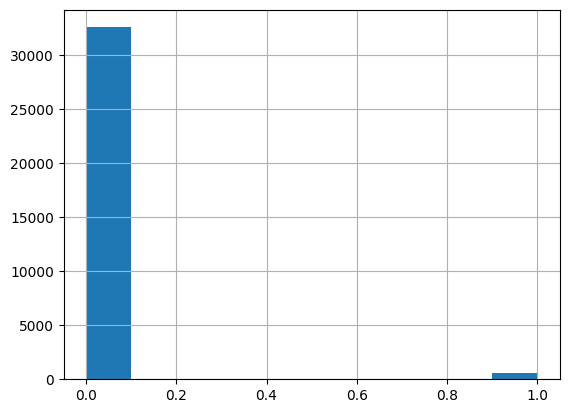

In [3]:
print(train['target'].value_counts())
train['target'].hist()
plt.show()

mode:0    45.0
Name: age_approx, dtype: float64


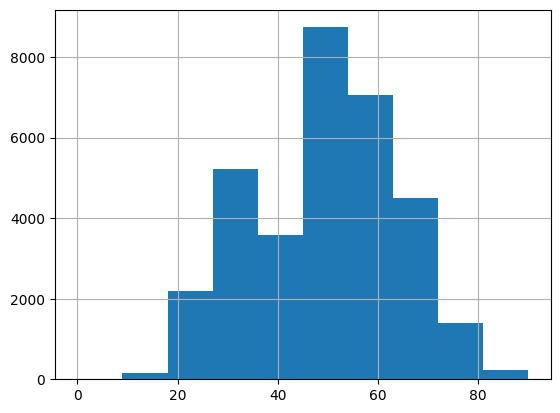

In [4]:
print(f"mode:{train['age_approx'].mode()}")
train['age_approx'].hist()
plt.show()

In [5]:
train['age_approx'].value_counts()

age_approx
45.0    4466
50.0    4270
55.0    3824
40.0    3576
60.0    3240
35.0    2850
65.0    2527
30.0    2358
70.0    1968
25.0    1544
75.0     981
20.0     655
80.0     419
85.0     149
15.0     132
90.0      80
10.0      17
0.0        2
Name: count, dtype: int64

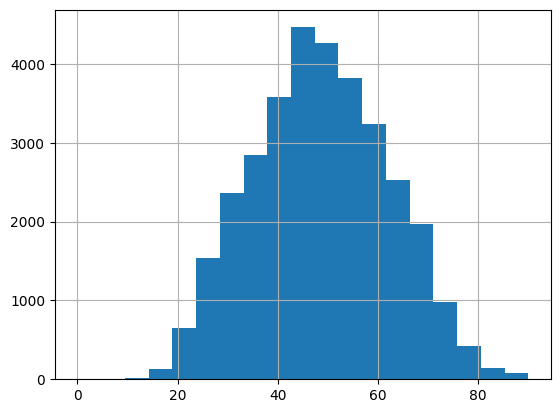

In [6]:
train['age_approx'].hist(bins=len(train['age_approx'].unique()))
plt.show()

In [7]:
imgs = os.listdir('/kaggle/input/melanoma224/jpeg224/train')
imgs[:5]

['ISIC_2801761.jpg',
 'ISIC_4442506.jpg',
 'ISIC_0375775.jpg',
 'ISIC_9054603.jpg',
 'ISIC_1691175.jpg']

# One hot encoding for metadata

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [9]:
train.isna().sum()

image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64

In [10]:
from sklearn.preprocessing import OneHotEncoder

cols = ["sex", "age_approx", "anatom_site_general_challenge"]
selected_cols = train[cols]
oh_encoder = OneHotEncoder()
oh_encoded = oh_encoder.fit_transform(selected_cols)
categories = oh_encoder.categories_

In [11]:
oh_encoder.transform([['female', 10.0, 'torso']]).toarray()

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


array([[1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [12]:
new_columns = oh_encoder.get_feature_names_out(cols)

In [13]:
train_clean = pd.DataFrame(oh_encoded.toarray(), columns=new_columns)

In [14]:
train_clean.isna().sum()

sex_female                                       0
sex_male                                         0
sex_nan                                          0
age_approx_0.0                                   0
age_approx_10.0                                  0
age_approx_15.0                                  0
age_approx_20.0                                  0
age_approx_25.0                                  0
age_approx_30.0                                  0
age_approx_35.0                                  0
age_approx_40.0                                  0
age_approx_45.0                                  0
age_approx_50.0                                  0
age_approx_55.0                                  0
age_approx_60.0                                  0
age_approx_65.0                                  0
age_approx_70.0                                  0
age_approx_75.0                                  0
age_approx_80.0                                  0
age_approx_85.0                

## Train set and validation set

In [15]:
from sklearn.model_selection import train_test_split

_, val = train_test_split(train, test_size=0.33, shuffle=True, random_state=42, stratify=train['target'])
"""
stratify hace que a la hora de hacer los dataset de train o validation no nos carguemos todos los valores que tienen 1 en uno de los dos datasets.
ya que hay muy pocos en comparacion con los de 0. entonces como que los distribuye en partes iguales
"""
val.shape

(10932, 8)

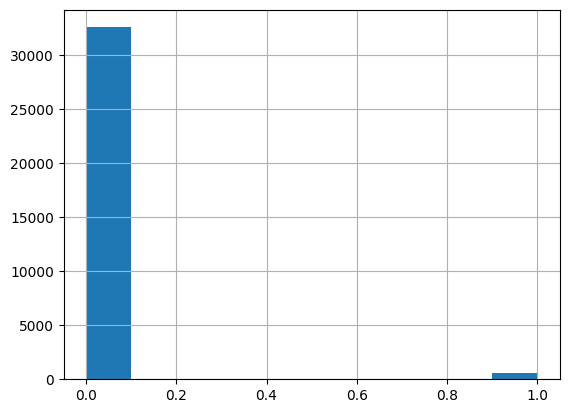

In [16]:
train['target'].hist()
plt.show()

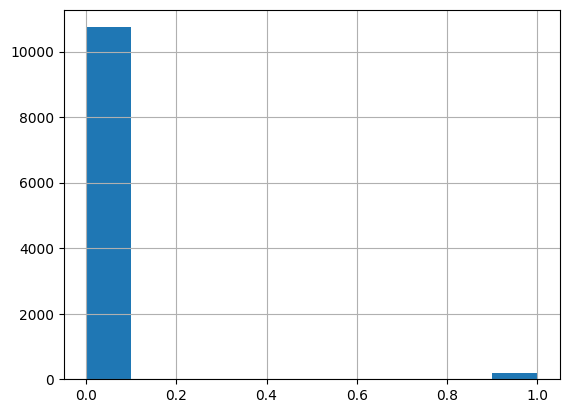

In [17]:
val['target'].hist()
plt.show()

# PyTorch baseline

In [18]:
import torch
import torchvision
from skimage import io
from fastprogress import master_bar, progress_bar

torch.__version__

'2.0.0'

In [19]:
val.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
10136,ISIC_3141629,IP_2412574,male,70.0,torso,unknown,benign,0
10282,ISIC_3184390,IP_3511494,male,45.0,upper extremity,unknown,benign,0
32285,ISIC_9750885,IP_7121757,female,35.0,upper extremity,unknown,benign,0
27522,ISIC_8330906,IP_8091497,male,45.0,torso,unknown,benign,0
25522,ISIC_7746898,IP_9879000,male,30.0,lower extremity,unknown,benign,0


In [20]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [21]:
train['path'] = [f'/kaggle/input/melanoma224/jpeg224/train/{img}.jpg' for img in train['image_name']]
val['path'] = [f'/kaggle/input/melanoma224/jpeg224/train/{img}.jpg' for img in val['image_name']]

## Pytorch dataset

In [22]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, images, meta, labels=None, train=True, cache=False, trans=None):
        self.cache = cache
        self.images = [self.load_img(img) for img in images] if cache else images
        meta = oh_encoder.transform(meta).toarray()
        self.meta = torch.tensor(meta).float()
        self.train = train
        self.trans = trans
        if train: self.labels = [torch.tensor([label]).float() for label in labels]
    
    def __len__(self):
        return len(self.images)
    
    def load_img(self, img):
        return io.imread(img)
    
    def __getitem__(self, ix):    
        img = self.images[ix] if self.cache else self.load_img(self.images[ix])
        if self.trans:
            img = self.trans(image=img)['image']
        if self.train:
            return torch.from_numpy(img), self.meta[ix], self.labels[ix]
        return torch.from_numpy(img), self.meta[ix]

trans = Compose([
    Flip(p=0.6), Transpose(), CropAndPad(p=0.2, percent=-0.1),
])

In [23]:
dataset = {
    'train': Dataset(train['path'], train[cols], train['target'], cache=True, trans=trans),
    'val': Dataset(val['path'], val[cols], val['target'], cache=True, trans=trans),
}

## Sample of the images

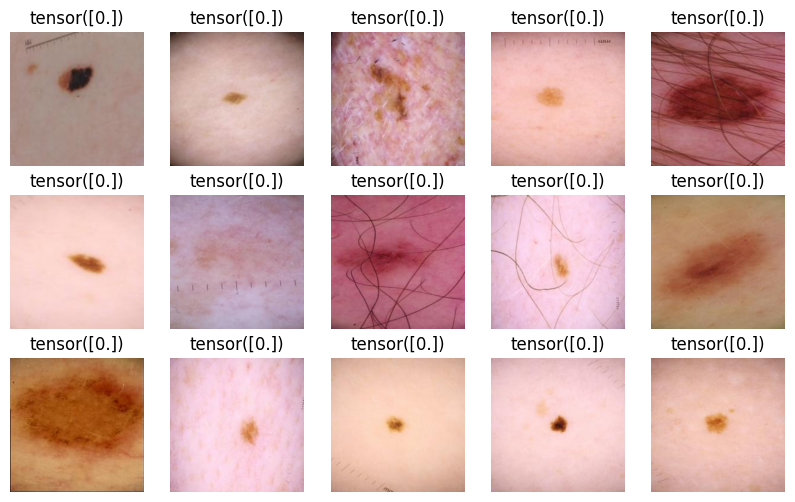

In [24]:
import random

r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(dataset['train']) - 1)
        img, meta, label = dataset['train'][ix]
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
plt.show()

In [25]:
meta

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

## Building the model

para trabajar con cnns en pytorch, debemos tener los canales como (batch_size, canales, alto, ancho).

por eso hicimos la transformacion de (b, h, w, c) -> (b, c, h, w)


In [26]:
class NN(torch.nn.Module):
    def __init__(self, inputs=29):
        super().__init__()
        # encoder de imagenes
        resnet = torchvision.models.resnet101(weights=True)
        for param in resnet.parameters():
            param.requires_grad = False # no aplicar los gradientes
        self.encoder = torch.nn.Sequential(*list(resnet.children())[:-1]) # conecta capas secuencialmente
        
        # encoder para metadata
        self.meta_encoder = torch.nn.Sequential(
            torch.nn.Linear(inputs, 100),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(100, 3),
            torch.nn.ReLU(inplace=True))
        
        # head. el head del backbone
        self.head = torch.nn.Linear(2048+3, 1)
        
    def forward(self, x, y):
        B, H, W, C = x.shape
        x = (x / 255.).float().view(B, C, H, W)
        x = self.encoder(x)
        x = x.view(B, -1) # reshape
        y = self.meta_encoder(y)
        z = torch.cat([x, y], -1)
        z = self.head(z)
        
        return z

## Instantiate the model

In [27]:
BATCH_SIZE = 64

model = NN()

output = model(torch.randn(BATCH_SIZE, 224, 224, 3), torch.randn(BATCH_SIZE, 29))
output.shape

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 219MB/s]


torch.Size([64, 1])

## Pytorch dataloader

In [28]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=BATCH_SIZE, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=BATCH_SIZE),
}

In [29]:
imgs, meta, labels = next(iter(dataloader['train']))

imgs.shape, meta.shape, labels.shape

(torch.Size([64, 224, 224, 3]), torch.Size([64, 29]), torch.Size([64, 1]))

## Move the model to GPU

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## AUC error metric

In [31]:
from sklearn.metrics import roc_auc_score

def AUC(outputs, labels):
    outputs = torch.sigmoid(outputs)
    outputs = outputs.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    auc = roc_auc_score(labels, outputs)
    return auc

# Training the model

In [32]:
model = NN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss() # this loss apply sigmoid itself, and it's better mathematically

epochs = 12
validation_steps = 15

mb = master_bar(range(1, epochs+1))
best_auc = 0

model.to(device)

for epoch in mb:
    train_loss = []
    model.train() # training mode
    for batch in progress_bar(dataloader['train'], parent=mb):
        imgs, meta, labels = batch
        imgs, meta, labels = imgs.to(device), meta.to(device), labels.to(device)
        outputs = model(imgs, meta)
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        #torch.cuda.empty_cache()
        loss.backward()
        optimizer.step() # apply the gradient
        train_loss.append(loss.item())
        mb.child.comment = f'loss: {np.mean(train_loss):.5f}'
        
    val_loss = []
    model.eval() # evaluation mode
    validation_step = 0
    val_outputs = torch.tensor([])
    val_targets = torch.tensor([])
    with torch.no_grad():
        for batch in progress_bar(dataloader['val'], parent=mb):
            imgs, meta, labels = batch
            imgs, meta, labels = imgs.to(device), meta.to(device), labels.to(device)
            outputs = model(imgs, meta)
            loss = criterion(outputs, labels)
            val_loss.append(loss.item())
            mb.child.comment = f'val_loss: {np.mean(val_loss):.5f}'
            val_outputs = torch.cat([val_outputs, outputs.cpu()])
            val_targets = torch.cat([val_targets, labels.cpu()])
            validation_step += 1
            if validation_step > validation_steps:
                break
                
    auc = AUC(val_outputs, val_targets)
    if auc > best_auc:
        best_auc = auc
        torch.save(model, 'model.pth') # saving the model
        
    mb.write(f'epoch: {epoch} | train_loss: {np.mean(train_loss):.5f} | epoch: {epoch} | val_loss: {np.mean(val_loss):.5f} | auc_loss: {auc:.5f}')

## Let's see the performance with the testset

In [33]:
test = pd.read_csv('/kaggle/input/melanoma224/test.csv')
test['path'] = [f'/kaggle/input/melanoma224/jpeg224/test/{img}.jpg' for img in test['image_name']]

test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,path
0,ISIC_0052060,IP_3579794,male,70.0,NaN,/kaggle/input/melanoma224/jpeg224/test/ISIC_00...
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,/kaggle/input/melanoma224/jpeg224/test/ISIC_00...
2,ISIC_0058510,IP_7960270,female,55.0,torso,/kaggle/input/melanoma224/jpeg224/test/ISIC_00...
3,ISIC_0073313,IP_6375035,female,50.0,torso,/kaggle/input/melanoma224/jpeg224/test/ISIC_00...
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,/kaggle/input/melanoma224/jpeg224/test/ISIC_00...


In [34]:
test_dataset = Dataset(test['path'], test[cols], train=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=200)

In [35]:
imgs, meta = next(iter(test_dataloader))
imgs.shape, meta.shape

(torch.Size([200, 224, 224, 3]), torch.Size([200, 29]))

## Loading the model and testing

In [36]:
model_save = torch.load('/kaggle/working/model.pth')
model_save.to(device)
model_save.eval()
preds = torch.tensor([]).to(device)

# we dont need to calculate grads during testing
with torch.no_grad():
    for imgs, meta in progress_bar(test_dataloader):
        imgs, meta = imgs.to(device), meta.to(device)
        outputs = model(imgs, meta)
        outputs = torch.sigmoid(outputs)
        preds = torch.cat([preds, outputs.view(-1)])